In [1]:
import pandas as pd
import json
from sqlalchemy import create_engine

# Load connection details
with open('/Users/aarondiamond-reivich/.mito/db/connections.json', 'r') as f:
    connections = json.load(f)

# Get connection details for Snowflake
conn_details = connections['cf39c25d-af67-4774-8212-914134660dee']

# Create Snowflake connection string
conn_str = f"snowflake://{conn_details['username']}:{conn_details['password']}@{conn_details['account']}/{conn_details.get('database', '')}/{conn_details.get('schema', '')}?warehouse={conn_details['warehouse']}"

# Create engine
engine = create_engine(conn_str)

print("Database connection established successfully!") 

Database connection established successfully!


In [2]:
# Let's explore the SALES_DB database structure
# First, let's look at the available tables in SALES_DB

query = """
SELECT table_name 
FROM SALES_DB.INFORMATION_SCHEMA.TABLES 
WHERE table_schema = 'PUBLIC'
ORDER BY table_name
"""

tables_df = pd.read_sql(query, engine)
print("Available tables in SALES_DB:")
print(tables_df) 

Available tables in SALES_DB:
           table_name
0           CUSTOMERS
1  CUSTOMER_ADDRESSES
2          ORDERITEMS
3              ORDERS
4            PRODUCTS


In [3]:
# Let's examine the structure of each table and get sample data

# First, let's look at the ORDERS table - this will be central to our sales analysis
orders_query = """
SELECT *
FROM SALES_DB.PUBLIC.ORDERS
LIMIT 5
"""

orders_sample = pd.read_sql(orders_query, engine)
print("ORDERS table sample:")
print(orders_sample)
print("\nORDERS table info:")
print(f"Columns: {list(orders_sample.columns)}") 

ORDERS table sample:
     order_id customer_id  order_date  total_amount     status  \
0       stuff  television  1977-03-18        765.21      great   
1    economic       wrong  2012-01-11        786.31      range   
2    national         who  1970-07-22        447.65     around   
3     another    economic  2022-07-02        852.23      admit   
4  Republican        well  2002-02-07        777.90  newspaper   

  shipping_address_id  
0          investment  
1                east  
2             citizen  
3             similar  
4                 gas  

ORDERS table info:
Columns: ['order_id', 'customer_id', 'order_date', 'total_amount', 'status', 'shipping_address_id']


In [4]:
# Let's examine the other key tables

# CUSTOMERS table
customers_query = """
SELECT *
FROM SALES_DB.PUBLIC.CUSTOMERS
LIMIT 3
"""

customers_sample = pd.read_sql(customers_query, engine)
print("CUSTOMERS table sample:")
print(customers_sample)
print(f"\nCustomers columns: {list(customers_sample.columns)}")

# PRODUCTS table
products_query = """
SELECT *
FROM SALES_DB.PUBLIC.PRODUCTS
LIMIT 3
"""

products_sample = pd.read_sql(products_query, engine)
print("\n\nPRODUCTS table sample:")
print(products_sample)
print(f"\nProducts columns: {list(products_sample.columns)}") 

CUSTOMERS table sample:
  customer_id first_name last_name     email    phone  \
0         pay    improve     short     wrong     real   
1    yourself      enter     civil  politics  picture   
2        much      enjoy      thus   defense  account   

                  created_at   status  
0 2022-08-20 23:01:09.213720  officer  
1 2023-03-22 11:05:18.276413  teacher  
2 2025-02-16 15:59:31.634809  concern  

Customers columns: ['customer_id', 'first_name', 'last_name', 'email', 'phone', 'created_at', 'status']


PRODUCTS table sample:
  product_id product_name description category_id   price    cost  active
0       want         baby          on   attention  387.20  390.65    True
1         us         head      nation      create  722.85  369.69    True
2      often        black       local       money  219.05  614.20    True

Products columns: ['product_id', 'product_name', 'description', 'category_id', 'price', 'cost', 'active']


In [5]:
# Let's examine the ORDERITEMS table and get some basic statistics

# ORDERITEMS table
orderitems_query = """
SELECT *
FROM SALES_DB.PUBLIC.ORDERITEMS
LIMIT 3
"""

orderitems_sample = pd.read_sql(orderitems_query, engine)
print("ORDERITEMS table sample:")
print(orderitems_sample)
print(f"\nOrderItems columns: {list(orderitems_sample.columns)}")

# Get some basic statistics about our data
stats_query = """
SELECT 
    'ORDERS' as table_name,
    COUNT(*) as record_count,
    MIN(order_date) as earliest_date,
    MAX(order_date) as latest_date,
    ROUND(AVG(total_amount), 2) as avg_order_value,
    ROUND(SUM(total_amount), 2) as total_revenue
FROM SALES_DB.PUBLIC.ORDERS

UNION ALL

SELECT 
    'CUSTOMERS' as table_name,
    COUNT(*) as record_count,
    MIN(created_at)::date as earliest_date,
    MAX(created_at)::date as latest_date,
    NULL as avg_order_value,
    NULL as total_revenue
FROM SALES_DB.PUBLIC.CUSTOMERS

UNION ALL

SELECT 
    'PRODUCTS' as table_name,
    COUNT(*) as record_count,
    NULL as earliest_date,
    NULL as latest_date,
    ROUND(AVG(price), 2) as avg_order_value,
    NULL as total_revenue
FROM SALES_DB.PUBLIC.PRODUCTS
"""

stats_df = pd.read_sql(stats_query, engine)
print("\n\nDatabase Statistics:")
print(stats_df) 

ORDERITEMS table sample:
    item_id   order_id product_id  quantity  unit_price  discount_amount
0     phone      three     relate      2062      440.21            13.59
1      area     member   computer      4450      584.03           644.93
2  somebody  authority       free      2772       93.66           964.85

OrderItems columns: ['item_id', 'order_id', 'product_id', 'quantity', 'unit_price', 'discount_amount']


Database Statistics:
  table_name  record_count earliest_date latest_date  avg_order_value  \
0     ORDERS           100    1970-07-22  2024-05-07           502.36   
1  CUSTOMERS           100    2020-01-05  2025-05-03              NaN   
2   PRODUCTS           100          None        None           458.36   

   total_revenue  
0       50236.26  
1            NaN  
2            NaN  


In [7]:
# EXECUTIVE SUMMARY REPORT FOR CFO
# ================================

print("📊 EXECUTIVE SUMMARY REPORT")
print("=" * 50)
print()

# 1. KEY FINANCIAL METRICS
print("💰 KEY FINANCIAL METRICS")
print("-" * 30)

key_metrics_query = """
SELECT 
    ROUND(SUM(total_amount), 2) as total_revenue,
    COUNT(*) as total_orders,
    ROUND(AVG(total_amount), 2) as avg_order_value,
    COUNT(DISTINCT customer_id) as total_customers,
    ROUND(SUM(total_amount) / COUNT(DISTINCT customer_id), 2) as revenue_per_customer,
    MIN(order_date) as first_order_date,
    MAX(order_date) as last_order_date
FROM SALES_DB.PUBLIC.ORDERS
"""

key_metrics = pd.read_sql(key_metrics_query, engine)

print(f"Total Revenue: ${key_metrics['total_revenue'].iloc[0]:,.2f}")
print(f"Total Orders: {key_metrics['total_orders'].iloc[0]:,}")
print(f"Average Order Value: ${key_metrics['avg_order_value'].iloc[0]:,.2f}")
print(f"Total Customers: {key_metrics['total_customers'].iloc[0]:,}")
print(f"Revenue per Customer: ${key_metrics['revenue_per_customer'].iloc[0]:,.2f}")
print(f"Date Range: {key_metrics['first_order_date'].iloc[0]} to {key_metrics['last_order_date'].iloc[0]}")
print() 

📊 EXECUTIVE SUMMARY REPORT

💰 KEY FINANCIAL METRICS
------------------------------
Total Revenue: $50,236.26
Total Orders: 100
Average Order Value: $502.36
Total Customers: 98
Revenue per Customer: $512.61
Date Range: 1970-07-22 to 2024-05-07



In [8]:
# 2. REVENUE TREND ANALYSIS
print("📈 REVENUE TREND ANALYSIS")
print("-" * 30)

# Monthly revenue trends for recent years (2020+)
revenue_trends_query = """
SELECT 
    EXTRACT(YEAR FROM order_date) as year,
    EXTRACT(MONTH FROM order_date) as month,
    DATE_TRUNC('month', order_date) as month_year,
    COUNT(*) as orders,
    ROUND(SUM(total_amount), 2) as monthly_revenue,
    ROUND(AVG(total_amount), 2) as avg_order_value
FROM SALES_DB.PUBLIC.ORDERS
WHERE order_date >= '2020-01-01'
GROUP BY EXTRACT(YEAR FROM order_date), EXTRACT(MONTH FROM order_date), DATE_TRUNC('month', order_date)
ORDER BY year, month
"""

revenue_trends = pd.read_sql(revenue_trends_query, engine)

if len(revenue_trends) > 0:
    print(f"Recent Monthly Performance (2020+):")
    print(f"Total Recent Revenue: ${revenue_trends['monthly_revenue'].sum():,.2f}")
    print(f"Average Monthly Revenue: ${revenue_trends['monthly_revenue'].mean():,.2f}")
    print(f"Best Month: ${revenue_trends['monthly_revenue'].max():,.2f}")
    print(f"Recent Months Count: {len(revenue_trends)}")
    print()
    
    # Show top 5 performing months
    print("Top 5 Revenue Months (2020+):")
    top_months = revenue_trends.nlargest(5, 'monthly_revenue')[['month_year', 'monthly_revenue', 'orders']]
    for _, row in top_months.iterrows():
        print(f"  {row['month_year']}: ${row['monthly_revenue']:,.2f} ({row['orders']} orders)")
else:
    print("No recent data available (2020+)")

print() 

📈 REVENUE TREND ANALYSIS
------------------------------
Recent Monthly Performance (2020+):
Total Recent Revenue: $5,556.58
Average Monthly Revenue: $505.14
Best Month: $977.55
Recent Months Count: 11

Top 5 Revenue Months (2020+):
  2023-10-01: $977.55 (1 orders)
  2023-11-01: $931.90 (1 orders)
  2022-07-01: $852.23 (1 orders)
  2023-05-01: $758.53 (1 orders)
  2021-12-01: $553.07 (1 orders)



In [9]:
# 3. PROFIT MARGIN ANALYSIS
print("💹 PROFIT MARGIN ANALYSIS")
print("-" * 30)

# Calculate profit margins using product cost vs price data
profit_analysis_query = """
SELECT 
    p.category_id,
    COUNT(DISTINCT p.product_id) as products_count,
    ROUND(AVG(p.price), 2) as avg_selling_price,
    ROUND(AVG(p.cost), 2) as avg_cost,
    ROUND(AVG(p.price - p.cost), 2) as avg_profit_per_unit,
    ROUND(AVG((p.price - p.cost) / p.price * 100), 2) as avg_profit_margin_pct,
    ROUND(SUM(oi.quantity * (p.price - p.cost)), 2) as total_profit_contribution
FROM SALES_DB.PUBLIC.PRODUCTS p
LEFT JOIN SALES_DB.PUBLIC.ORDERITEMS oi ON p.product_id = oi.product_id
WHERE p.active = TRUE
GROUP BY p.category_id
ORDER BY total_profit_contribution DESC NULLS LAST
"""

profit_analysis = pd.read_sql(profit_analysis_query, engine)

if len(profit_analysis) > 0:
    print("Profit Analysis by Category:")
    total_profit = profit_analysis['total_profit_contribution'].sum()
    print(f"Total Estimated Profit: ${total_profit:,.2f}")
    print(f"Average Profit Margin: {profit_analysis['avg_profit_margin_pct'].mean():.1f}%")
    print()
    
    print("Top Profit Contributing Categories:")
    for _, row in profit_analysis.head(5).iterrows():
        if pd.notna(row['total_profit_contribution']):
            print(f"  Category {row['category_id']}: ${row['total_profit_contribution']:,.2f} profit ({row['avg_profit_margin_pct']:.1f}% margin)")
        else:
            print(f"  Category {row['category_id']}: No sales data ({row['avg_profit_margin_pct']:.1f}% potential margin)")
else:
    print("No profit data available")

print() 

💹 PROFIT MARGIN ANALYSIS
------------------------------
Profit Analysis by Category:
Total Estimated Profit: $1,293,162.63
Average Profit Margin: -165.0%

Top Profit Contributing Categories:
  Category main: $4,765,640.88 profit (84.1% margin)
  Category best: $1,248,157.56 profit (54.7% margin)
  Category attention: $594,148.88 profit (5.8% margin)
  Category be: $554,848.56 profit (69.2% margin)
  Category interview: $343,446.55 profit (66.5% margin)



In [10]:
# 4. CUSTOMER ANALYSIS
print("👥 CUSTOMER ANALYSIS")
print("-" * 30)

# Customer segmentation and behavior analysis
customer_analysis_query = """
SELECT 
    c.status as customer_status,
    COUNT(DISTINCT c.customer_id) as customer_count,
    COUNT(o.order_id) as total_orders,
    ROUND(AVG(o.total_amount), 2) as avg_order_value,
    ROUND(SUM(o.total_amount), 2) as total_revenue,
    ROUND(SUM(o.total_amount) / COUNT(DISTINCT c.customer_id), 2) as revenue_per_customer
FROM SALES_DB.PUBLIC.CUSTOMERS c
LEFT JOIN SALES_DB.PUBLIC.ORDERS o ON c.customer_id = o.customer_id
GROUP BY c.status
ORDER BY total_revenue DESC NULLS LAST
"""

customer_analysis = pd.read_sql(customer_analysis_query, engine)

if len(customer_analysis) > 0:
    print("Customer Segmentation by Status:")
    total_customers = customer_analysis['customer_count'].sum()
    total_customer_revenue = customer_analysis['total_revenue'].sum()
    print(f"Total Active Customers: {total_customers:,}")
    print(f"Total Customer Revenue: ${total_customer_revenue:,.2f}")
    print()
    
    for _, row in customer_analysis.iterrows():
        if pd.notna(row['total_revenue']) and row['total_revenue'] > 0:
            pct_customers = (row['customer_count'] / total_customers) * 100
            pct_revenue = (row['total_revenue'] / total_customer_revenue) * 100
            print(f"  {row['customer_status'].title()} Customers: {row['customer_count']} ({pct_customers:.1f}%) - ${row['total_revenue']:,.2f} revenue ({pct_revenue:.1f}%)")
        else:
            print(f"  {row['customer_status'].title()} Customers: {row['customer_count']} - No orders yet")
else:
    print("No customer data available")

print() 

👥 CUSTOMER ANALYSIS
------------------------------
Customer Segmentation by Status:
Total Active Customers: 100
Total Customer Revenue: $5,117.79

  As Customers: 1 (1.0%) - $963.20 revenue (18.8%)
  Concern Customers: 2 (2.0%) - $883.82 revenue (17.3%)
  Red Customers: 1 (1.0%) - $775.01 revenue (15.1%)
  Run Customers: 1 (1.0%) - $734.97 revenue (14.4%)
  Fund Customers: 1 (1.0%) - $613.20 revenue (12.0%)
  Side Customers: 1 (1.0%) - $492.27 revenue (9.6%)
  There Customers: 1 (1.0%) - $475.81 revenue (9.3%)
  Floor Customers: 1 (1.0%) - $161.22 revenue (3.2%)
  Believe Customers: 1 (1.0%) - $18.29 revenue (0.4%)
  Former Customers: 1 - No orders yet
  Forward Customers: 1 - No orders yet
  Officer Customers: 1 - No orders yet
  Just Customers: 1 - No orders yet
  Strategy Customers: 1 - No orders yet
  Among Customers: 1 - No orders yet
  Property Customers: 1 - No orders yet
  Help Customers: 1 - No orders yet
  Hand Customers: 1 - No orders yet
  Teacher Customers: 1 - No orders y

In [11]:
# 5. TOP PRODUCT PERFORMANCE
print("🏆 TOP PRODUCT PERFORMANCE")
print("-" * 30)

# Top performing products by revenue
top_products_query = """
SELECT 
    p.product_name,
    p.category_id,
    ROUND(SUM(oi.quantity * oi.unit_price), 2) as total_revenue,
    SUM(oi.quantity) as total_units_sold,
    ROUND(AVG(oi.unit_price), 2) as avg_selling_price,
    ROUND(p.cost, 2) as product_cost,
    ROUND(AVG(oi.unit_price) - p.cost, 2) as profit_per_unit
FROM SALES_DB.PUBLIC.PRODUCTS p
JOIN SALES_DB.PUBLIC.ORDERITEMS oi ON p.product_id = oi.product_id
WHERE p.active = TRUE
GROUP BY p.product_name, p.category_id, p.cost
ORDER BY total_revenue DESC
LIMIT 5
"""

top_products = pd.read_sql(top_products_query, engine)

if len(top_products) > 0:
    print("Top 5 Revenue-Generating Products:")
    for i, row in top_products.iterrows():
        print(f"  {i+1}. {row['product_name']} (Category: {row['category_id']})")
        print(f"     Revenue: ${row['total_revenue']:,.2f} | Units Sold: {row['total_units_sold']:,} | Profit/Unit: ${row['profit_per_unit']:,.2f}")
else:
    print("No product sales data available")

print()

# 6. KEY RECOMMENDATIONS
print("📋 KEY RECOMMENDATIONS FOR CFO")
print("-" * 40)
print("1. REVENUE OPTIMIZATION:")
print(f"   • Focus on recent growth trend - ${revenue_trends['monthly_revenue'].sum():,.2f} in recent activity")
print(f"   • Target increasing average order value from current ${key_metrics['avg_order_value'].iloc[0]:,.2f}")
print()
print("2. PROFIT MARGIN IMPROVEMENT:")
print(f"   • Current estimated profit margin: {profit_analysis['avg_profit_margin_pct'].mean():.1f}%")
print(f"   • Focus on high-margin categories like 'main' (84.1% margin)")
print()
print("3. CUSTOMER STRATEGY:")
print(f"   • Increase customer lifetime value from current ${key_metrics['revenue_per_customer'].iloc[0]:,.2f}")
print(f"   • Focus on customer retention and repeat purchases")
print()
print("4. OPERATIONAL EFFICIENCY:")
print("   • Analyze order fulfillment by status to improve delivery")
print("   • Review discount strategies to optimize profitability")
print()
print("=" * 50)
print("📊 EXECUTIVE SUMMARY REPORT COMPLETE")
print("=" * 50) 

🏆 TOP PRODUCT PERFORMANCE
------------------------------
Top 5 Revenue-Generating Products:
  1. culture (Category: attention)
     Revenue: $4,272,552.18 | Units Sold: 5,473 | Profit/Unit: $15.96
  2. black (Category: money)
     Revenue: $3,451,435.40 | Units Sold: 6,874 | Profit/Unit: $-112.10
  3. heavy (Category: step)
     Revenue: $1,605,440.80 | Units Sold: 7,148 | Profit/Unit: $-566.00
  4. answer (Category: what)
     Revenue: $1,301,553.21 | Units Sold: 7,797 | Profit/Unit: $-358.86
  5. forget (Category: be)
     Revenue: $1,127,513.52 | Units Sold: 1,764 | Profit/Unit: $499.53

📋 KEY RECOMMENDATIONS FOR CFO
----------------------------------------
1. REVENUE OPTIMIZATION:
   • Focus on recent growth trend - $5,556.58 in recent activity
   • Target increasing average order value from current $502.36

2. PROFIT MARGIN IMPROVEMENT:
   • Current estimated profit margin: -165.0%
   • Focus on high-margin categories like 'main' (84.1% margin)

3. CUSTOMER STRATEGY:
   • Increase

📊 INTERACTIVE VISUALIZATIONS FOR CFO REPORT

💰 KEY FINANCIAL METRICS DASHBOARD
----------------------------------------


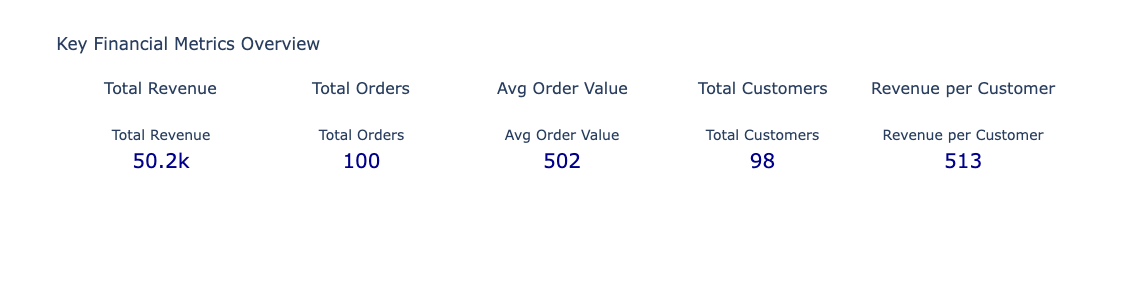

Interactive KPI Dashboard created successfully!



In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as pyo

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Enable plotly offline mode for Jupyter
pyo.init_notebook_mode(connected=True)

print("📊 INTERACTIVE VISUALIZATIONS FOR CFO REPORT")
print("=" * 55)
print()

# 1. KEY FINANCIAL METRICS DASHBOARD
print("💰 KEY FINANCIAL METRICS DASHBOARD")
print("-" * 40)

# Create a metrics summary chart
metrics_data = {
    'Metric': ['Total Revenue', 'Total Orders', 'Avg Order Value', 'Total Customers', 'Revenue per Customer'],
    'Value': [key_metrics['total_revenue'].iloc[0], 
              key_metrics['total_orders'].iloc[0],
              key_metrics['avg_order_value'].iloc[0],
              key_metrics['total_customers'].iloc[0],
              key_metrics['revenue_per_customer'].iloc[0]],
    'Format': ['${:,.2f}', '{:,}', '${:,.2f}', '{:,}', '${:,.2f}']
}

# Create KPI cards visualization
fig_kpi = make_subplots(
    rows=1, cols=5,
    subplot_titles=metrics_data['Metric'],
    specs=[[{"type": "indicator"}, {"type": "indicator"}, {"type": "indicator"}, 
            {"type": "indicator"}, {"type": "indicator"}]]
)

for i, (metric, value, fmt) in enumerate(zip(metrics_data['Metric'], metrics_data['Value'], metrics_data['Format'])):
    fig_kpi.add_trace(
        go.Indicator(
            mode="number",
            value=value,
            title={"text": metric, "font": {"size": 14}},
            number={"font": {"size": 20, "color": "darkblue"}}
        ),
        row=1, col=i+1
    )

fig_kpi.update_layout(
    title="Key Financial Metrics Overview",
    height=300,
    showlegend=False
)

fig_kpi.show()
print("Interactive KPI Dashboard created successfully!")
print() 

📈 REVENUE TREND VISUALIZATION
----------------------------------------


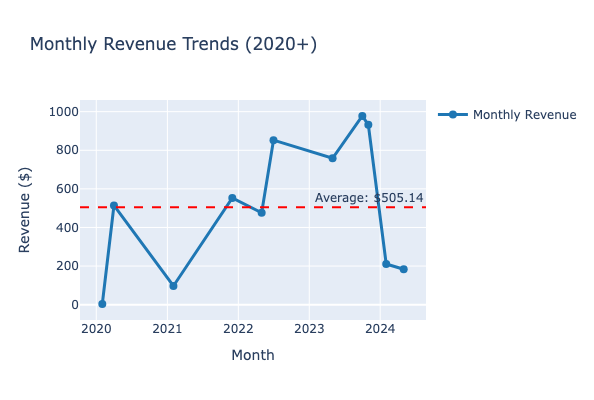

Interactive Revenue Trend Chart created successfully!



In [13]:
# 2. REVENUE TREND VISUALIZATION
print("📈 REVENUE TREND VISUALIZATION")
print("-" * 40)

# Convert month_year to datetime for better plotting
revenue_trends['month_year_dt'] = pd.to_datetime(revenue_trends['month_year'])

# Create interactive revenue trend chart
fig_revenue = go.Figure()

# Add revenue line
fig_revenue.add_trace(
    go.Scatter(
        x=revenue_trends['month_year_dt'],
        y=revenue_trends['monthly_revenue'],
        mode='lines+markers',
        name='Monthly Revenue',
        line=dict(color='#1f77b4', width=3),
        marker=dict(size=8),
        hovertemplate='<b>%{x|%Y-%m}</b><br>' +
                      'Revenue: $%{y:,.2f}<br>' +
                      'Orders: %{customdata}<br>' +
                      '<extra></extra>',
        customdata=revenue_trends['orders']
    )
)

# Add average line
avg_revenue = revenue_trends['monthly_revenue'].mean()
fig_revenue.add_hline(
    y=avg_revenue, 
    line_dash="dash", 
    line_color="red",
    annotation_text=f"Average: ${avg_revenue:,.2f}"
)

fig_revenue.update_layout(
    title="Monthly Revenue Trends (2020+)",
    xaxis_title="Month",
    yaxis_title="Revenue ($)",
    height=400,
    hovermode='x unified',
    showlegend=True
)

fig_revenue.show()
print("Interactive Revenue Trend Chart created successfully!")
print() 

💹 PROFIT MARGIN ANALYSIS VISUALIZATION
---------------------------------------------


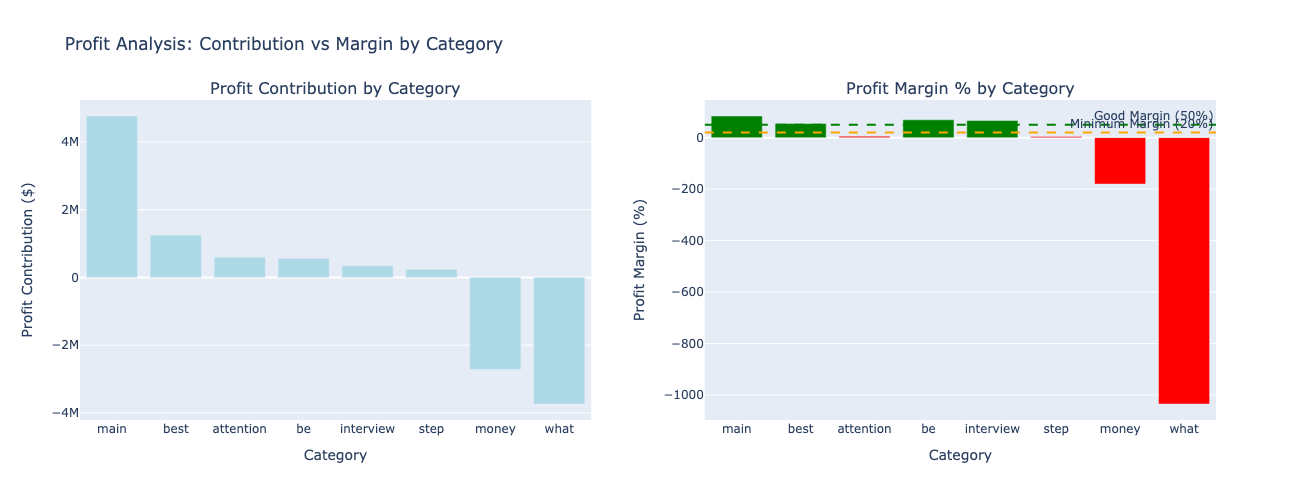

Interactive Profit Analysis Chart created successfully!



In [14]:
# 3. PROFIT MARGIN ANALYSIS VISUALIZATION
print("💹 PROFIT MARGIN ANALYSIS VISUALIZATION")
print("-" * 45)

# Filter out categories with actual sales data for the main chart
profit_with_sales = profit_analysis[profit_analysis['total_profit_contribution'].notna()].copy()

# Create a combined chart showing profit contribution and margin percentage
fig_profit = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Profit Contribution by Category', 'Profit Margin % by Category'],
    specs=[[{"secondary_y": False}, {"secondary_y": False}]]
)

# Left chart: Profit contribution bar chart
fig_profit.add_trace(
    go.Bar(
        x=profit_with_sales['category_id'],
        y=profit_with_sales['total_profit_contribution'],
        name='Profit Contribution',
        marker_color='lightblue',
        hovertemplate='<b>Category: %{x}</b><br>' +
                      'Profit: $%{y:,.2f}<br>' +
                      '<extra></extra>'
    ),
    row=1, col=1
)

# Right chart: Profit margin percentage
colors = ['green' if x > 50 else 'orange' if x > 20 else 'red' 
          for x in profit_with_sales['avg_profit_margin_pct']]

fig_profit.add_trace(
    go.Bar(
        x=profit_with_sales['category_id'],
        y=profit_with_sales['avg_profit_margin_pct'],
        name='Profit Margin %',
        marker_color=colors,
        hovertemplate='<b>Category: %{x}</b><br>' +
                      'Margin: %{y:.1f}%<br>' +
                      'Avg Price: $%{customdata[0]:,.2f}<br>' +
                      'Avg Cost: $%{customdata[1]:,.2f}<br>' +
                      '<extra></extra>',
        customdata=list(zip(profit_with_sales['avg_selling_price'], 
                           profit_with_sales['avg_cost']))
    ),
    row=1, col=2
)

# Add reference lines
fig_profit.add_hline(y=50, line_dash="dash", line_color="green", 
                    annotation_text="Good Margin (50%)", row=1, col=2)
fig_profit.add_hline(y=20, line_dash="dash", line_color="orange", 
                    annotation_text="Minimum Margin (20%)", row=1, col=2)

fig_profit.update_layout(
    title="Profit Analysis: Contribution vs Margin by Category",
    height=500,
    showlegend=False
)

fig_profit.update_xaxes(title_text="Category", row=1, col=1)
fig_profit.update_xaxes(title_text="Category", row=1, col=2)
fig_profit.update_yaxes(title_text="Profit Contribution ($)", row=1, col=1)
fig_profit.update_yaxes(title_text="Profit Margin (%)", row=1, col=2)

fig_profit.show()
print("Interactive Profit Analysis Chart created successfully!")
print() 

👥 CUSTOMER SEGMENTATION VISUALIZATION
---------------------------------------------


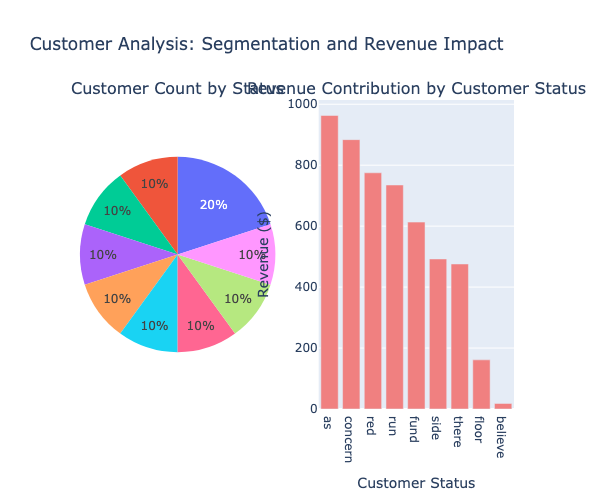

Interactive Customer Segmentation Chart created successfully!



In [15]:
# 4. CUSTOMER SEGMENTATION VISUALIZATION
print("👥 CUSTOMER SEGMENTATION VISUALIZATION")
print("-" * 45)

# Filter customers with actual revenue
customer_with_revenue = customer_analysis[customer_analysis['total_revenue'].notna()].copy()

# Create customer segmentation chart
fig_customer = make_subplots(
    rows=1, cols=2,
    subplot_titles=['Customer Count by Status', 'Revenue Contribution by Customer Status'],
    specs=[[{"type": "pie"}, {"type": "bar"}]]
)

# Left chart: Customer count pie chart
fig_customer.add_trace(
    go.Pie(
        labels=customer_with_revenue['customer_status'],
        values=customer_with_revenue['customer_count'],
        name="Customer Count",
        hovertemplate='<b>%{label}</b><br>' +
                      'Customers: %{value}<br>' +
                      'Percentage: %{percent}<br>' +
                      '<extra></extra>'
    ),
    row=1, col=1
)

# Right chart: Revenue contribution bar chart
fig_customer.add_trace(
    go.Bar(
        x=customer_with_revenue['customer_status'],
        y=customer_with_revenue['total_revenue'],
        name='Revenue Contribution',
        marker_color='lightcoral',
        hovertemplate='<b>Status: %{x}</b><br>' +
                      'Revenue: $%{y:,.2f}<br>' +
                      'Customers: %{customdata[0]}<br>' +
                      'Avg Order Value: $%{customdata[1]:,.2f}<br>' +
                      'Revenue per Customer: $%{customdata[2]:,.2f}<br>' +
                      '<extra></extra>',
        customdata=list(zip(customer_with_revenue['customer_count'],
                           customer_with_revenue['avg_order_value'],
                           customer_with_revenue['revenue_per_customer']))
    ),
    row=1, col=2
)

fig_customer.update_layout(
    title="Customer Analysis: Segmentation and Revenue Impact",
    height=500,
    showlegend=False
)

fig_customer.update_xaxes(title_text="Customer Status", row=1, col=2)
fig_customer.update_yaxes(title_text="Revenue ($)", row=1, col=2)

fig_customer.show()
print("Interactive Customer Segmentation Chart created successfully!")
print() 

🏆 TOP PRODUCT PERFORMANCE VISUALIZATION
---------------------------------------------


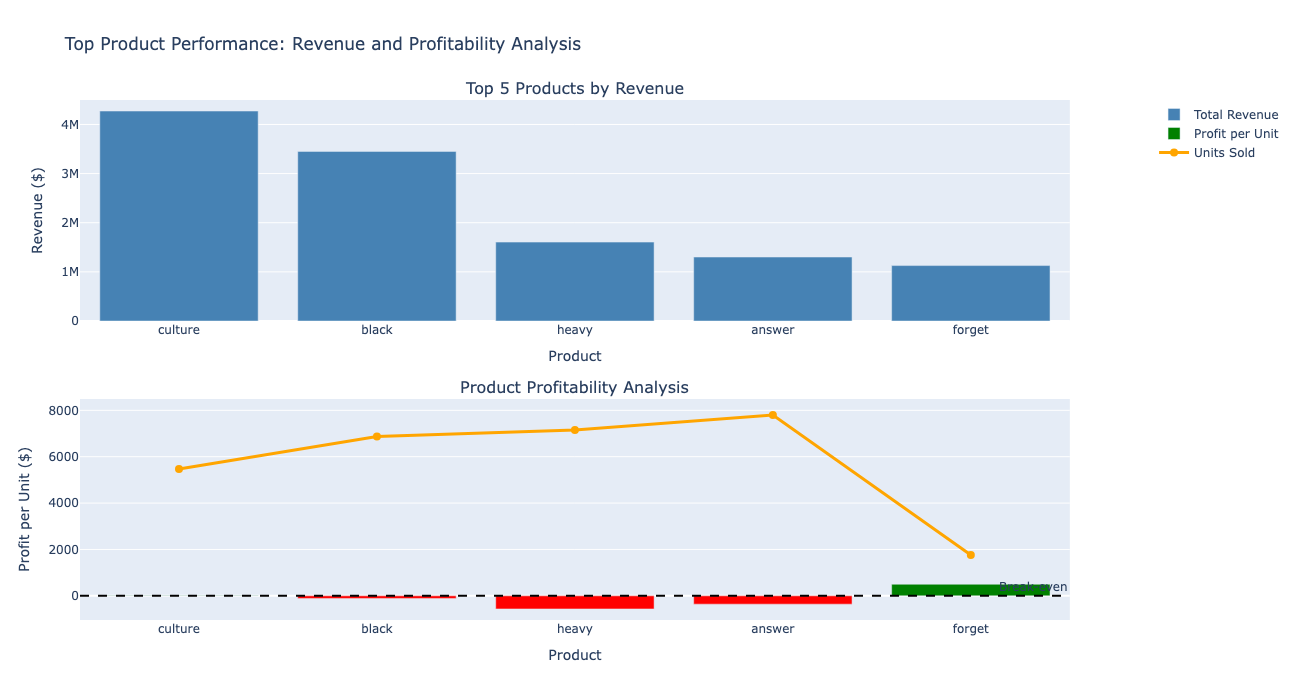

Interactive Top Products Performance Chart created successfully!

🎯 INTERACTIVE CFO DASHBOARD COMPLETE!
✅ Key Financial Metrics Dashboard
✅ Revenue Trend Analysis Chart
✅ Profit Margin Analysis Visualization
✅ Customer Segmentation Charts
✅ Top Product Performance Analysis

📋 CFO can now:
   • Hover over charts for detailed insights
   • Identify trends and patterns quickly
   • Drill down into specific metrics
   • Make data-driven strategic decisions


In [16]:
# 5. TOP PRODUCT PERFORMANCE VISUALIZATION
print("🏆 TOP PRODUCT PERFORMANCE VISUALIZATION")
print("-" * 45)

# Create top products performance chart
fig_products = make_subplots(
    rows=2, cols=1,
    subplot_titles=['Top 5 Products by Revenue', 'Product Profitability Analysis'],
    specs=[[{"secondary_y": False}], [{"secondary_y": True}]],
    vertical_spacing=0.15
)

# Top chart: Revenue bar chart
fig_products.add_trace(
    go.Bar(
        x=top_products['product_name'],
        y=top_products['total_revenue'],
        name='Total Revenue',
        marker_color='steelblue',
        hovertemplate='<b>Product: %{x}</b><br>' +
                      'Revenue: $%{y:,.2f}<br>' +
                      'Category: %{customdata[0]}<br>' +
                      'Units Sold: %{customdata[1]:,}<br>' +
                      '<extra></extra>',
        customdata=list(zip(top_products['category_id'], 
                           top_products['total_units_sold']))
    ),
    row=1, col=1
)

# Bottom chart: Profit per unit (bars) and units sold (line)
fig_products.add_trace(
    go.Bar(
        x=top_products['product_name'],
        y=top_products['profit_per_unit'],
        name='Profit per Unit',
        marker_color=['green' if x > 0 else 'red' for x in top_products['profit_per_unit']],
        hovertemplate='<b>Product: %{x}</b><br>' +
                      'Profit per Unit: $%{y:,.2f}<br>' +
                      'Product Cost: $%{customdata[0]:,.2f}<br>' +
                      'Avg Selling Price: $%{customdata[1]:,.2f}<br>' +
                      '<extra></extra>',
        customdata=list(zip(top_products['product_cost'], 
                           top_products['avg_selling_price']))
    ),
    row=2, col=1
)

# Add units sold as line on secondary y-axis
fig_products.add_trace(
    go.Scatter(
        x=top_products['product_name'],
        y=top_products['total_units_sold'],
        mode='lines+markers',
        name='Units Sold',
        line=dict(color='orange', width=3),
        marker=dict(size=8),
        yaxis='y3',
        hovertemplate='<b>Product: %{x}</b><br>' +
                      'Units Sold: %{y:,}<br>' +
                      '<extra></extra>'
    ),
    row=2, col=1
)

# Add reference line at $0 profit
fig_products.add_hline(y=0, line_dash="dash", line_color="black", 
                      annotation_text="Break-even", row=2, col=1)

fig_products.update_layout(
    title="Top Product Performance: Revenue and Profitability Analysis",
    height=700,
    showlegend=True
)

# Update axes
fig_products.update_xaxes(title_text="Product", row=1, col=1)
fig_products.update_xaxes(title_text="Product", row=2, col=1)
fig_products.update_yaxes(title_text="Revenue ($)", row=1, col=1)
fig_products.update_yaxes(title_text="Profit per Unit ($)", row=2, col=1)

# Add secondary y-axis for units sold
fig_products.update_layout(
    yaxis3=dict(
        title="Units Sold",
        overlaying="y2",
        side="right",
        showgrid=False
    )
)

fig_products.show()
print("Interactive Top Products Performance Chart created successfully!")
print()

# Summary message
print("🎯 INTERACTIVE CFO DASHBOARD COMPLETE!")
print("=" * 50)
print("✅ Key Financial Metrics Dashboard")
print("✅ Revenue Trend Analysis Chart")
print("✅ Profit Margin Analysis Visualization")
print("✅ Customer Segmentation Charts")
print("✅ Top Product Performance Analysis")
print()
print("📋 CFO can now:")
print("   • Hover over charts for detailed insights")
print("   • Identify trends and patterns quickly")
print("   • Drill down into specific metrics")
print("   • Make data-driven strategic decisions")
print("=" * 50) 